In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
!pip install matplotlib google-cloud-storage

In [2]:
import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time
import glob

from typing import List, Text

from PIL import Image

import cv2
import numpy as np
import pandas as pd
import tabulate
import seaborn as sns
from tqdm import tqdm


import tensorflow as tf

import matplotlib.pyplot as plt


### Authenticate


The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [3]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuration

In [5]:
#@title Global params

class Globals:
  # GCP project with GCS bucket of interest
  gcp_project = 'dx-scin-public' #@param

  # GCS bucket with data to read
  gcs_bucket_name = 'dx-scin-public-data' #@param

  # CSV of case metadata to read
  cases_csv = 'dataset/scin_cases.csv' #@param

  # CSV of label metadata to read
  labels_csv = 'dataset/scin_labels.csv' #@param

  # Images directory
  gcs_images_dir = 'dataset/images/' #@param

  ### Key column names
  image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
  weighted_skin_condition_label = "weighted_skin_condition_label"
  skin_condition_label = "dermatologist_skin_condition_on_label_name"

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  cases_df = None

  # pd.DataFrame for the loaded labels_csv
  cases_and_labels_df = None

print(f'GCS bucket name: {Globals.gcs_bucket_name}')
print(f'cases_csv: {Globals.cases_csv}')
print(f'labels_csv: {Globals.labels_csv}')
print(f'images dir: {Globals.gcs_images_dir}')


GCS bucket name: dx-scin-public-data
cases_csv: dataset/scin_cases.csv
labels_csv: dataset/scin_labels.csv
images dir: dataset/images/


## Load dataset

In [6]:
#@title Create a dataframe that contains the metadata and condition labels

from google.cloud import storage

def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)

def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(
    Globals.gcs_bucket_name
)
Globals.cases_df = initialize_df_with_metadata(Globals.gcs_bucket, Globals.cases_csv)
Globals.cases_and_labels_df = augment_metadata_with_labels(Globals.cases_df, Globals.gcs_bucket, Globals.labels_csv)
print(len(Globals.cases_and_labels_df))

5033


In [7]:
Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [8]:
Globals.cases_and_labels_df.sample(1)

case_id source release  year    age_group  \
557  -280318703075879215   SCIN   1.0.0  2023  AGE_UNKNOWN   

             sex_at_birth fitzpatrick_skin_type  \
557  OTHER_OR_UNSPECIFIED                   NaN   

    race_ethnicity_american_indian_or_alaska_native race_ethnicity_asian  \
557                                             NaN                  NaN   

    race_ethnicity_black_or_african_american  ...  \
557                                      NaN  ...   

    dermatologist_gradable_for_fitzpatrick_skin_type_1  \
557                                                YES   

    dermatologist_gradable_for_fitzpatrick_skin_type_2  \
557                                                NaN   

    dermatologist_gradable_for_fitzpatrick_skin_type_3  \
557                                                NaN   

    dermatologist_fitzpatrick_skin_type_label_1  \
557                                        FST2   

    dermatologist_fitzpatrick_skin_type_label_2  \
557                                         NaN   

    dermatologist_fitzpatrick_skin_type_label_3  \
557                                         NaN   

    gradable_for_monk_skin_tone_india gradable_for_monk_skin_tone_us  \
557                              True                           True   

    monk_skin_tone_label_india monk_skin_tone_label_us  
557                        2.0                     2.0  

[1 rows x 73 columns]

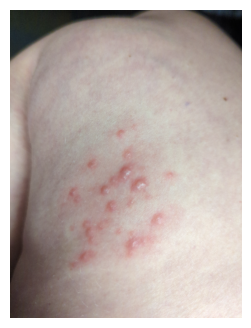

{'Herpes Zoster': 0.67, 'Herpes Simplex': 0.33}


In [9]:
#@title Display the images for a case (and condition labels, optionally)
import random

import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def display_image(bucket, image_path):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size=4
  f, axarr = plt.subplots(1, 1, figsize = (figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

def display_images_for_case(df, case_id="", print_condition_labels=True):
  # Use a random case if none is provided:
  if case_id:
    matched_df = df[df['case_id'] == case_id]
  else:
    matched_df = df.sample(1)

  image_paths = matched_df[Globals.image_path_columns].values.tolist()[0]
  for path in image_paths:
    if isinstance(path, str):
      display_image(Globals.gcs_bucket, path)
  if print_condition_labels:
    condition_labels = matched_df[[Globals.weighted_skin_condition_label]].values.tolist()[0]
    for label in condition_labels:
      if isinstance(label, str):
        print(label)

# display_images_for_case(Globals.cases_and_labels_df, "-1000600354148496558")
display_images_for_case(Globals.cases_and_labels_df)


In [10]:
#@title Print metadata stats
def print_metadata_stats(df: pd.DataFrame) -> None:
  print(f'Num cases: {len(df)}')

  # Number of cases with 1, 2, or 3 images
  image_1_cnt = df["image_1_path"].count()
  image_2_cnt = df["image_2_path"].count()
  image_3_cnt = df["image_3_path"].count()
  print(f'Num cases with image_1_path set: {image_1_cnt}')
  print(f'Num cases with image_2_path set: {image_2_cnt}')
  print(f'Num cases with image_3_path set: {image_3_cnt}')
  print(f'Total images: {image_1_cnt + image_2_cnt + image_3_cnt}')

  # Sex at birth:
  print('\nSelf-reported Sex at Birth:')
  sab = collections.Counter(df['sex_at_birth'].dropna())
  total = sum(sab.values())
  for k in sorted(sab):
    print(f'  {k} {sab[k]} ({100.0*sab[k]/total:.1f}%)')

  # FST distribution:
  print('\nSelf-reported Fitzpatrick Skin Type:')
  fst = collections.Counter(df['fitzpatrick_skin_type'].dropna())
  total = sum(fst.values())
  for k in sorted(fst):
    print(f'  {k} {fst[k]} ({100.0*fst[k]/total:.1f}%)')


print_metadata_stats(Globals.cases_and_labels_df)

Num cases: 5033
Num cases with image_1_path set: 5033
Num cases with image_2_path set: 3085
Num cases with image_3_path set: 2289
Total images: 10407

Self-reported Sex at Birth:
  FEMALE 1666 (33.1%)
  MALE 807 (16.0%)
  OTHER_OR_UNSPECIFIED 2559 (50.9%)

Self-reported Fitzpatrick Skin Type:
  FST1 188 (7.5%)
  FST2 542 (21.7%)
  FST3 661 (26.4%)
  FST4 427 (17.1%)
  FST5 214 (8.5%)
  FST6 143 (5.7%)
  NONE_IDENTIFIED 328 (13.1%)


In [11]:
#@title Add combined_race_ethnicity column

def merge_race_ethnicity_columns(row):
  combined = []
  for col in row.keys():
    if col.startswith("race_ethnicity_") and row[col] == 'YES':
      combined.append(col[len("race_ethnicity_"):])
  return ",".join(combined)

Globals.cases_and_labels_df["combined_race_ethnicity"] = Globals.cases_and_labels_df.apply(merge_race_ethnicity_columns, axis=1)
Globals.cases_and_labels_df[["case_id", "combined_race_ethnicity"]]

case_id            combined_race_ethnicity
0     -1000600354148496558                                   
1     -1002039107727665188                                   
2     -1003358831658393077  hispanic_latino_or_spanish_origin
3     -1003826561155964328                                   
4     -1003844406100696311                              white
...                    ...                                ...
5028    973759811984683137       two_or_more_after_mitigation
5029    973872028150293734                                   
5030    983265958160210646          black_or_african_american
5031    995820220956352730       two_or_more_after_mitigation
5032    998890198757718998   american_indian_or_alaska_native

[5033 rows x 2 columns]

In [12]:
#@title Print race/ethnicity distribution

def print_race_ethnicity_dist(df):
  c = collections.Counter(df['combined_race_ethnicity'].dropna())
  total = sum(c.values())
  for k in sorted(c):
    if not k:
      k = 'unspecified'
    print(f'  {k}: {c[k]} ({100.0*c[k]/total:.1f}%)')

print_race_ethnicity_dist(Globals.cases_and_labels_df)

  unspecified: 0 (0.0%)
  american_indian_or_alaska_native: 48 (1.0%)
  american_indian_or_alaska_native,white: 25 (0.5%)
  asian: 85 (1.7%)
  asian,white: 11 (0.2%)
  black_or_african_american: 267 (5.3%)
  black_or_african_american,hispanic_latino_or_spanish_origin: 11 (0.2%)
  black_or_african_american,white: 20 (0.4%)
  hispanic_latino_or_spanish_origin: 224 (4.5%)
  hispanic_latino_or_spanish_origin,white: 55 (1.1%)
  middle_eastern_or_north_african: 7 (0.1%)
  native_hawaiian_or_pacific_islander: 4 (0.1%)
  other_race: 16 (0.3%)
  prefer_not_to_answer: 34 (0.7%)
  two_or_more_after_mitigation: 83 (1.6%)
  white: 1762 (35.0%)


## Important Functions

**Variables**
* df_original: The full, unmodified dataset containing all cases, metadata, and image paths. This is equivalent to Globals.cases_and_labels_df and can be used like a normal pandas DataFrame.
* df_filtered: A working copy of the dataset that you can safely modify, filter, or clean without affecting the original.
* image_dir : Use this directory to access images within google cloud


**Functions**
* read_image_from_gcs(gcs_path)
  - Downloads and decodes an image directly from your GCS bucket using the path stored in the dataset (e.g. "dataset/images/12345.png").
* get_all_image_paths()
  - Extracts all unique image paths from the three image columns (image_1_path, image_2_path, image_3_path) in the dataset.
* show_case_images(case_id)
  - Displays all available images for a given case_id directly from GCS.
* convert_to_binary_var(col_name)
  - convert to binary values

  Note: add instructions if we want to analyze/change/decode all images together

In [13]:
df_original = Globals.cases_and_labels_df

In [34]:
df_filtered = df_original.copy()

In [15]:
image_dir = "/content/gcs_mount/dataset/images"

In [16]:
def read_image_from_gcs(gcs_path):
    """Reads and decodes an image from GCS (relative path)."""
    try:
        blob = Globals.gcs_bucket.blob(gcs_path)
        img_bytes = blob.download_as_bytes()
        img_array = np.frombuffer(img_bytes, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        if img is None:
            return None
        # Convert BGR (OpenCV) → RGB (matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb
    except Exception as e:
        print(f"Failed to read {gcs_path}: {e}")
        return None


In [17]:
def get_all_image_paths():
    """Flatten all image_1/2/3 columns into a unique list of image paths."""
    image_cols = ['image_1_path', 'image_2_path', 'image_3_path']
    all_paths = (
        Globals.cases_and_labels_df[image_cols]
        .stack()
        .dropna()
        .unique()
        .tolist()
    )
    print(f"📸 Found {len(all_paths)} unique image paths.")
    return all_paths


In [18]:
def show_case_images(case_id):
    """Display all available images for a given case_id."""
    row = Globals.cases_and_labels_df[Globals.cases_and_labels_df["case_id"] == str(case_id)]
    if row.empty:
        print(f"No case found for ID {case_id}")
        return

    paths = row[['image_1_path', 'image_2_path', 'image_3_path']].dropna(axis=1).values.flatten()
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(paths, 1):
        img = read_image_from_gcs(path)
        plt.subplot(1, len(paths), i)
        plt.imshow(img)
        plt.title(f"{os.path.basename(path)}", fontsize=9)
        plt.axis("off")
    plt.suptitle(f"Case ID: {case_id}", fontsize=12)
    plt.tight_layout()
    plt.show()


In [19]:
def convert_to_binary_var(col_name):
  df_filtered[col_name].replace('YES', 1, inplace = True)
  df_filtered[col_name].fillna(0, inplace = True)
  print(df_filtered[col_name].value_counts())
  print("")


## Skin Condition label information

In [ ]:
#@title Print condition distribution

def print_condition_distribution(df, top_n_conditions=50):
  # Any condition that shows up in a label
  condition_ctr = collections.Counter()
  print(f'Distribution of conditions in "{Globals.skin_condition_label}" column:')
  for entry in df[Globals.skin_condition_label].dropna():
    condition_ctr.update(eval(entry))
  for condition, cnt in condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')
  print(f'Distribution of conditions in "{Globals.weighted_skin_condition_label}" column:')
  weighted_condition_ctr = collections.Counter()
  for entry in df[Globals.weighted_skin_condition_label].dropna():
    weighted_condition_ctr.update(eval(entry).keys())
  for condition, cnt in weighted_condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')

print_condition_distribution(Globals.cases_and_labels_df)


Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  Eczema: 1211
  Allergic Contact Dermatitis: 952
  Insect Bite: 449
  Urticaria: 377
  Psoriasis: 348
  Folliculitis: 297
  Irritant Contact Dermatitis: 254
  Tinea: 232
  Herpes Zoster: 157
  Drug Rash: 156
  Herpes Simplex: 152
  Impetigo: 124
  Acute dermatitis, NOS: 124
  Hypersensitivity: 115
  Acne: 109
  Pigmented purpuric eruption: 108
  Leukocytoclastic Vasculitis: 105
  Lichen planus/lichenoid eruption: 94
  Pityriasis rosea: 89
  Viral Exanthem: 87
  Lichen Simplex Chronicus: 85
  Stasis Dermatitis: 83
  Keratosis pilaris: 72
  CD - Contact dermatitis: 70
  Scabies: 68
  Tinea Versicolor: 68
  Granuloma annulare: 65
  Molluscum Contagiosum: 64
  Rosacea: 57
  Abrasion, scrape, or scab: 51
  O/E - ecchymoses present: 51
  Seborrheic Dermatitis: 50
  Acute and chronic dermatitis: 47
  Photodermatitis: 45
  Cellulitis: 45
  Abscess: 43
  Verruca vulgaris: 42
  SCC/SCCIS: 38
  Purpura: 38
  Inter

In [ ]:
#@title Print column names
print(Globals.cases_and_labels_df.columns)

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

## Display distributions of self-reported condition info

Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}


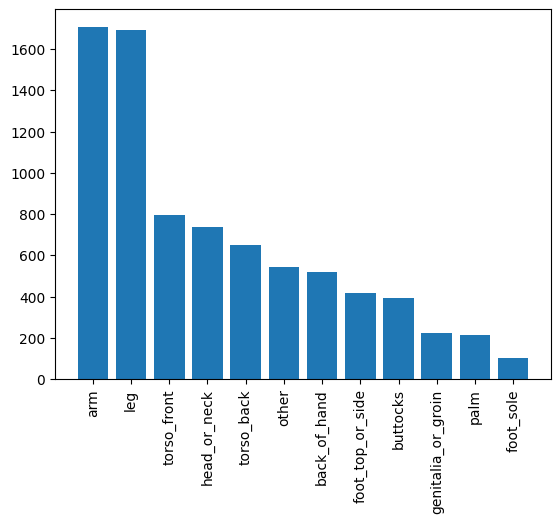

In [ ]:
#@title Display body part distribution

def get_distribution_columns(df, prefix):
  cols = [c for c in df.columns if c.startswith(prefix)]
  dist = collections.Counter()
  for c in cols:
    name = c[len(prefix):]
    val = sum(df[c] == "YES")
    dist[name] = val
  return dist

def get_distribution_and_display(df, prefix):
  ctr = get_distribution_columns(df, prefix)
  dist = dict(ctr.most_common())
  print(f'Distribution data: {dist}')
  names = list(dist.keys())
  counts = list(dist.values())
  plt.bar(names, counts)
  plt.xticks(rotation=90)  # Rotate labels by 90 degrees
  plt.show()

# Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}
get_distribution_and_display(Globals.cases_and_labels_df, "body_parts_")


Distribution data: {'raised_or_bumpy': 2915, 'rough_or_flaky': 1032, 'flat': 822, 'fluid_filled': 629}


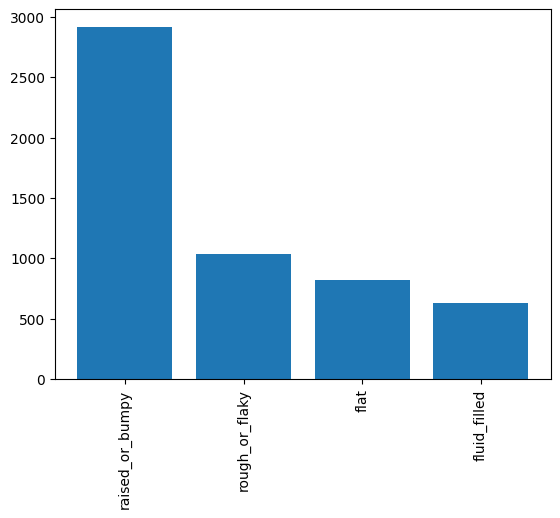

In [ ]:
#@title Display texture distribution
get_distribution_and_display(Globals.cases_and_labels_df, "textures_")

Distribution data: {'itching': 2712, 'bothersome_appearance': 1530, 'increasing_size': 1013, 'burning': 988, 'pain': 734, 'darkening': 385, 'no_relevant_experience': 308, 'bleeding': 225}


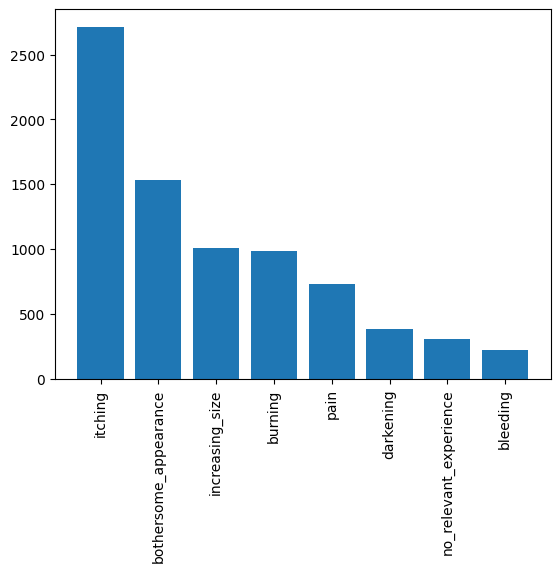

In [ ]:
#@title Display condition symptom dist
get_distribution_and_display(Globals.cases_and_labels_df, "condition_symptoms_")

Distribution data: {'no_relevant_symptoms': 2841, 'fatigue': 415, 'joint_pain': 300, 'shortness_of_breath': 139, 'chills': 120, 'mouth_sores': 96, 'fever': 90}


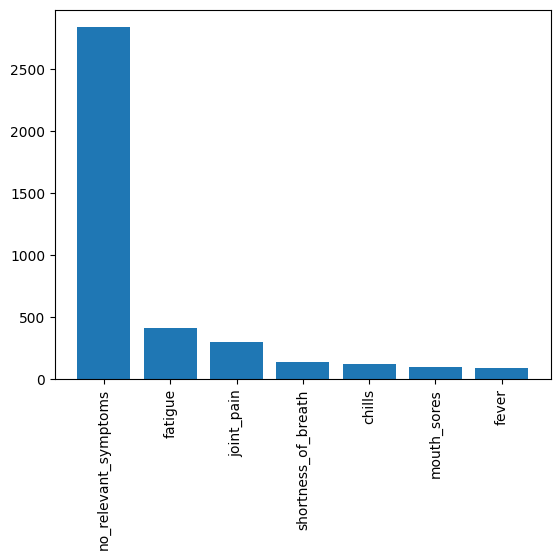

In [ ]:
#@title Display other symptoms distribution
get_distribution_and_display(Globals.cases_and_labels_df, "other_symptoms_")

## Feature Cleaning, Preprocessing, and Exploration

In [20]:
# Checking the null values in case_id
print(df_filtered['case_id'].isnull().sum())
# 0 Null/NaN values

# Checking the count of rows in dataset
print(df_filtered['case_id'].count())

print(df_filtered.shape)

0
5033
(5033, 74)


In [21]:
# Age Group
# Unknown ages are already accounted for by the AGE_UNKNOWN age_group value.
# No handling of missing values for this column/feature.
print(df_filtered['age_group'].count())
df_filtered['age_group'].value_counts()

# Most of the ages in the dataset are unknown.
# Ignoring the unknown ages group, majority of the known ages are young adults (Age 18 to 29).
# Less representation in dataset for elders (ages 60 to 79) results in fewer skin condition images of elders.

5032


age_group
AGE_UNKNOWN     2864
AGE_18_TO_29     769
AGE_40_TO_49     435
AGE_30_TO_39     422
AGE_50_TO_59     322
AGE_60_TO_69     165
AGE_70_TO_79      55
Name: count, dtype: int64

In [22]:
# Sex at Birth
print(df_filtered['sex_at_birth'].count())
df_filtered['sex_at_birth'].value_counts()

# Most sex at birth values are other or unspecified.
# Females at birth have greater representation in dataset than males at birth.

5032


sex_at_birth
OTHER_OR_UNSPECIFIED    2559
FEMALE                  1666
MALE                     807
Name: count, dtype: int64

In [23]:
# Fitzpatrick Skin Type
print(df_filtered['fitzpatrick_skin_type'].count())
df_filtered['fitzpatrick_skin_type'].value_counts()

# Significiant amount of missing values for this column. NaN values will become the value 'NONE_IDENTIFIED'.

2503


fitzpatrick_skin_type
FST3               661
FST2               542
FST4               427
NONE_IDENTIFIED    328
FST5               214
FST1               188
FST6               143
Name: count, dtype: int64

In [24]:
df_filtered['fitzpatrick_skin_type'].fillna('NONE_IDENTIFIED', inplace = True)
print(df_filtered['fitzpatrick_skin_type'].count())
df_filtered['fitzpatrick_skin_type'].value_counts()

5033


/tmp/ipython-input-657253139.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['fitzpatrick_skin_type'].fillna('NONE_IDENTIFIED', inplace = True)


fitzpatrick_skin_type
NONE_IDENTIFIED    2858
FST3                661
FST2                542
FST4                427
FST5                214
FST1                188
FST6                143
Name: count, dtype: int64

In [25]:
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_1'].count())
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_1'].value_counts())
print(" ")

print(df_filtered['dermatologist_fitzpatrick_skin_type_label_2'].count())
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_2'].value_counts())
print(" ")

print(df_filtered['dermatologist_fitzpatrick_skin_type_label_3'].count())
print(df_filtered['dermatologist_fitzpatrick_skin_type_label_3'].value_counts())

# What does the 0 indicate? No image at that image path? Or no FST score identified for an image?

4302
dermatologist_fitzpatrick_skin_type_label_1
FST2    1432
FST3    1332
FST4     719
FST1     391
FST5     359
FST6      69
Name: count, dtype: int64
 
634
dermatologist_fitzpatrick_skin_type_label_2
FST2    243
FST3    172
FST4    119
FST5     52
FST1     42
FST6      6
Name: count, dtype: int64
 
631
dermatologist_fitzpatrick_skin_type_label_3
FST2    234
FST3    190
FST4    119
FST5     58
FST1     30
Name: count, dtype: int64


In [26]:
print(df_filtered['monk_skin_tone_label_india'].count())
print(df_filtered['monk_skin_tone_label_india'].value_counts())

# Q: Are the monk scale numbers 0-indexed? Does monk score of 0 mean monk score of 1 or does it mean no monk score?

5019
monk_skin_tone_label_india
2.0    2427
3.0    1591
4.0     522
1.0     187
5.0     177
6.0      63
7.0      35
8.0      14
9.0       3
Name: count, dtype: int64


In [27]:
print(df_filtered['monk_skin_tone_label_us'].count())
print(df_filtered['monk_skin_tone_label_us'].value_counts())
# Range is from 0 to 10 -> verify this

5005
monk_skin_tone_label_us
2.0     1660
3.0     1265
4.0      687
1.0      577
5.0      361
6.0      248
7.0      137
8.0       57
9.0       11
10.0       2
Name: count, dtype: int64


In [28]:
print(df_filtered['dermatologist_skin_condition_on_label_name'].count())
print(df_filtered['dermatologist_skin_condition_on_label_name'].value_counts()[:15])

5033
dermatologist_skin_condition_on_label_name
[]                                                                1972
['Eczema']                                                         120
['Urticaria']                                                       81
['Eczema', 'Allergic Contact Dermatitis']                           67
['Allergic Contact Dermatitis', 'Irritant Contact Dermatitis']      60
['Allergic Contact Dermatitis']                                     42
['Folliculitis']                                                    37
['Urticaria', 'Insect Bite', 'Allergic Contact Dermatitis']         36
['Insect Bite']                                                     27
['Acute dermatitis, NOS']                                           27
['Tinea', 'Psoriasis', 'Eczema']                                    23
['Urticaria', 'Allergic Contact Dermatitis']                        22
['Psoriasis', 'Eczema']                                             21
['O/E - ecchymoses present'] 

In [29]:
print(df_filtered['dermatologist_skin_condition_confidence'].count())
print(df_filtered['dermatologist_skin_condition_confidence'].value_counts()[:15])
# Overall high confidence in skin condition image scoring by dermatologists (lots of 5 values)

5033
dermatologist_skin_condition_confidence
[]           1972
[5]           312
[4]           208
[2, 2, 2]     178
[2, 2]        176
[1, 1, 1]     170
[4, 2]        112
[3]           103
[2, 4]        100
[1, 1]         63
[3, 2]         45
[1, 5, 1]      40
[5, 1, 1]      39
[2]            34
[2, 3]         33
Name: count, dtype: int64


Note (mahek): we should remove the columns with empty fields for dermatologist label and confidence

Maybe we should also analyze demographics of low confidence scores images

In [31]:
import ast

df_filtered['dermatologist_skin_condition_on_label_name'] = df_filtered[
    'dermatologist_skin_condition_on_label_name'
].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

unlabeled = df_filtered[
    df_filtered['dermatologist_skin_condition_on_label_name'].apply(lambda x: len(x) == 0)
]
print(f"Total unlabeled cases: {len(unlabeled)}")
unlabeled[['case_id', 'image_1_path', 'image_2_path', 'image_3_path']].head(3)

Total unlabeled cases: 1972


case_id                             image_1_path  \
3   -1003826561155964328  dataset/images/-5332065579713135540.png   
12  -1036016816671158395  dataset/images/-4468092162346386244.png   
14  -1037438006618214143  dataset/images/-7305545407741188289.png   

                               image_2_path  \
3   dataset/images/-6353431708064969797.png   
12   dataset/images/-630763911369653872.png   
14                                      NaN   

                              image_3_path  
3    dataset/images/742075435141960831.png  
12  dataset/images/4131134852171985059.png  
14                                     NaN

In [32]:
race_cols = [
    'race_ethnicity_american_indian_or_alaska_native',
    'race_ethnicity_asian',
    'race_ethnicity_black_or_african_american',
    'race_ethnicity_hispanic_latino_or_spanish_origin',
    'race_ethnicity_middle_eastern_or_north_african',
    'race_ethnicity_native_hawaiian_or_pacific_islander',
    'race_ethnicity_white',
    'race_ethnicity_other_race',
    'race_ethnicity_prefer_not_to_answer'
]

race_summary = {}

for col in race_cols:
    # Normalize to uppercase to be safe, then count "YES"
    count = unlabeled[col].astype(str).str.upper().eq('YES').sum()
    percent = (count / len(unlabeled)) * 100
    race_summary[col] = {'count': count, 'percent': percent}

race_df = pd.DataFrame(race_summary).T.sort_values('count', ascending=False)
race_df


count    percent
race_ethnicity_white                                680.0  34.482759
race_ethnicity_black_or_african_american             84.0   4.259635
race_ethnicity_hispanic_latino_or_spanish_origin     74.0   3.752535
race_ethnicity_asian                                 23.0   1.166329
race_ethnicity_american_indian_or_alaska_native      20.0   1.014199
race_ethnicity_prefer_not_to_answer                  12.0   0.608519
race_ethnicity_other_race                             6.0   0.304260
race_ethnicity_native_hawaiian_or_pacific_islander    3.0   0.152130
race_ethnicity_middle_eastern_or_north_african        1.0   0.050710

In [ ]:
# Check for rows where *all* race columns are NaN AND combined_race is NaN
mask_all_nan = unlabeled[race_cols + ['combined_race']].isna().all(axis=1)

count_all_nan = mask_all_nan.sum()
total_unlabeled = len(unlabeled)
percent_all_nan = (count_all_nan / total_unlabeled) * 100

print(f"Rows with all race fields (including combined_race) as NaN: {count_all_nan}/{total_unlabeled} ({percent_all_nan:.2f}%)")


Rows with all race fields (including combined_race) as NaN: 1078/1972 (54.67%)


In [ ]:
# Race distribution among unlabeled images
race_counts = unlabeled['combined_race'].value_counts(dropna=False)
race_percent = unlabeled['combined_race'].value_counts(normalize=True, dropna=False) * 100

race_df = pd.DataFrame({
    'count_unlabeled': race_counts,
    'percent_unlabeled': race_percent
}).reset_index().rename(columns={'index': 'combined_race'})

race_df


combined_race  count_unlabeled  \
0                                                 NaN             1078   
1                                               WHITE              658   
2                           BLACK_OR_AFRICAN_AMERICAN               73   
3                   HISPANIC_LATINO_OR_SPANISH_ORIGIN               58   
4                                               ASIAN               23   
5                    AMERICAN_INDIAN_OR_ALASKA_NATIVE               17   
6                        TWO_OR_MORE_AFTER_MITIGATION               17   
7                                PREFER_NOT_TO_ANSWER               12   
8             HISPANIC_LATINO_OR_SPANISH_ORIGIN,WHITE               12   
9                     BLACK_OR_AFRICAN_AMERICAN,WHITE                7   
10                                         OTHER_RACE                6   
11  BLACK_OR_AFRICAN_AMERICAN,HISPANIC_LATINO_OR_S...                4   
12                NATIVE_HAWAIIAN_OR_PACIFIC_ISLANDER                3   
13             AMERICAN_INDIAN_OR_ALASKA_NATIVE,WHITE                3   
14                    MIDDLE_EASTERN_OR_NORTH_AFRICAN                1   

    percent_unlabeled  
0           54.665314  
1           33.367140  
2            3.701826  
3            2.941176  
4            1.166329  
5            0.862069  
6            0.862069  
7            0.608519  
8            0.608519  
9            0.354970  
10           0.304260  
11           0.202840  
12           0.152130  
13           0.152130  
14           0.050710

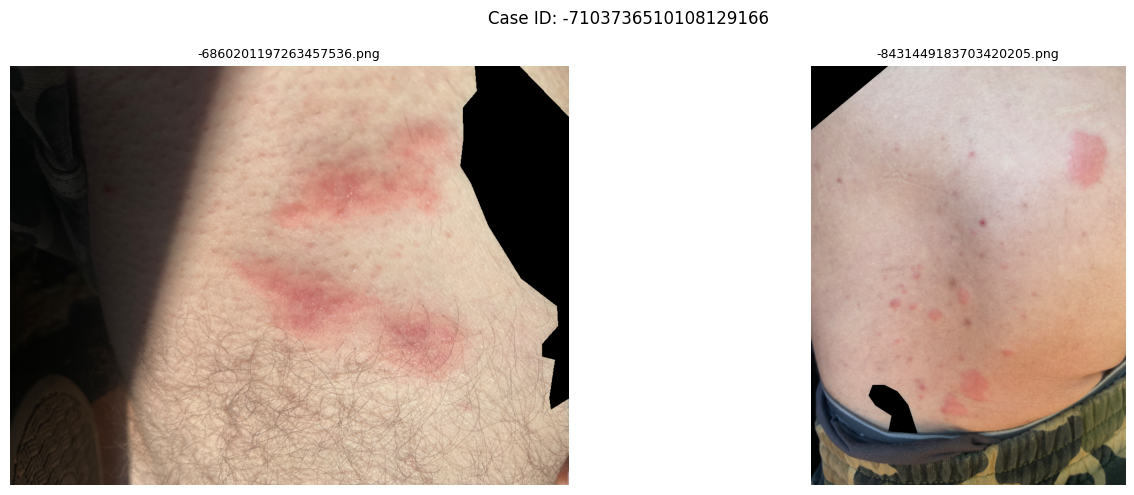

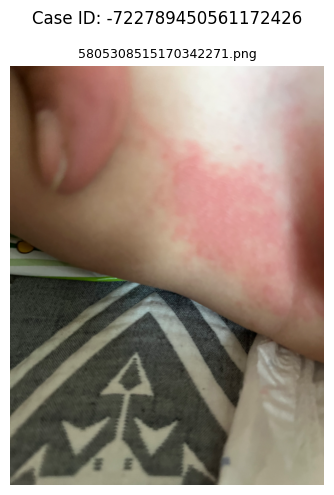

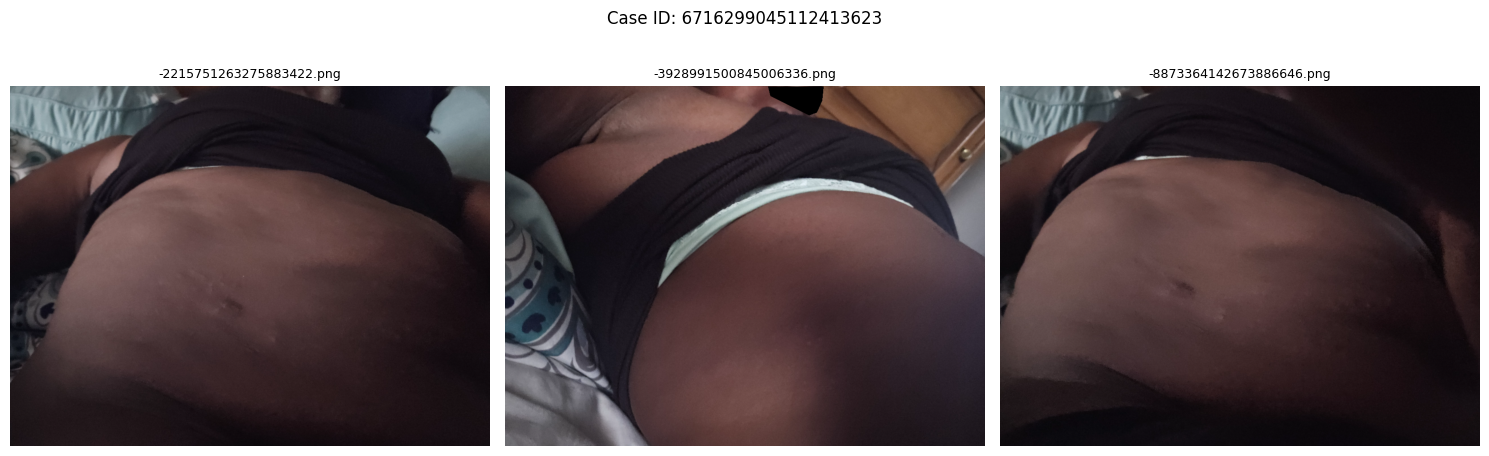

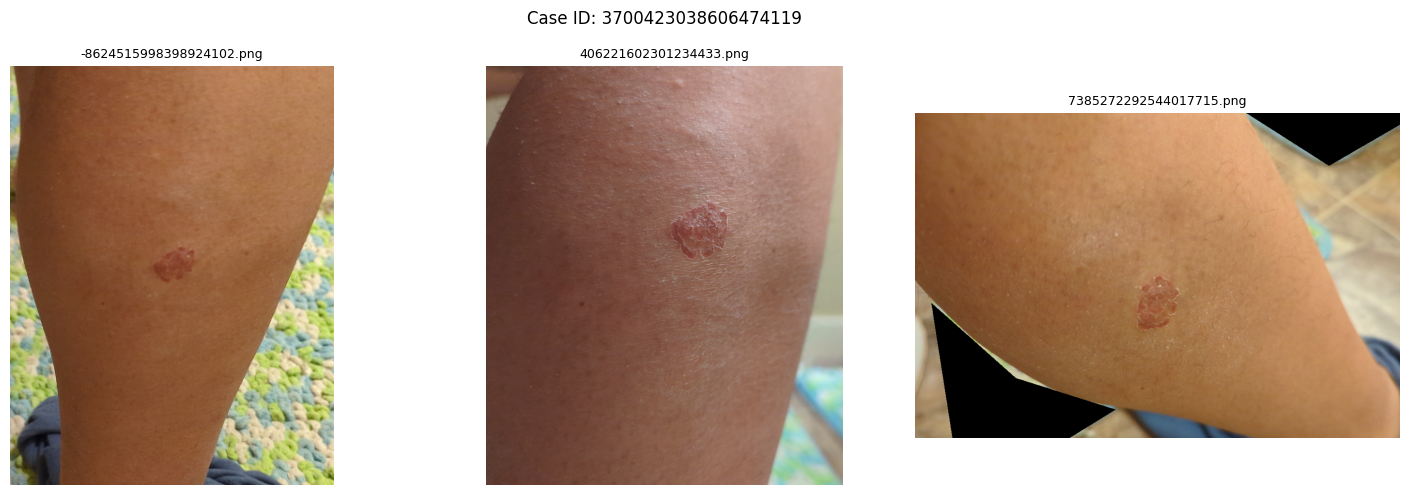

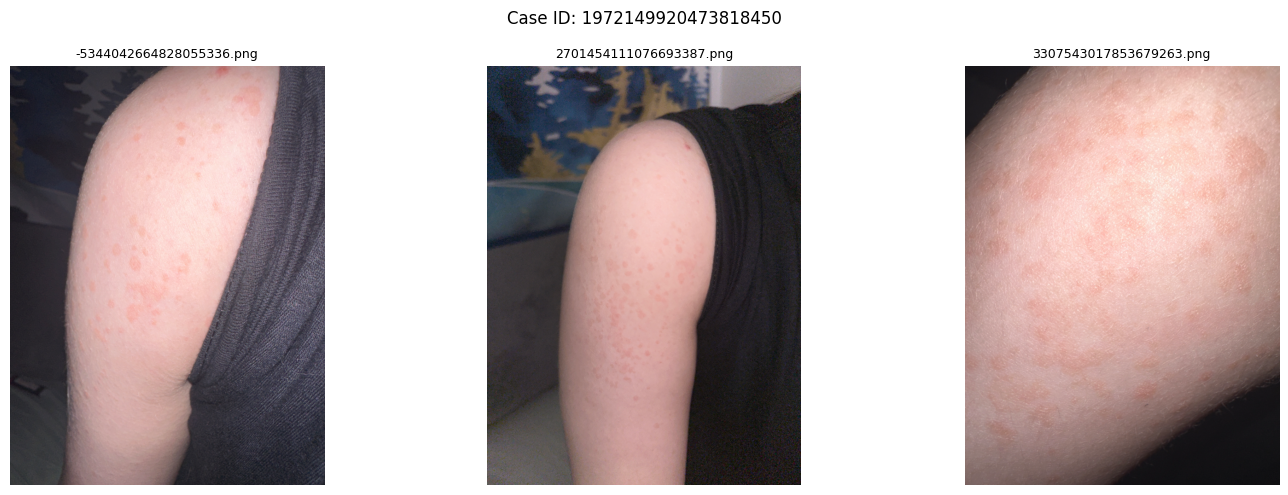

In [ ]:
for case_id in unlabeled.sample(5, random_state=42)['case_id']:
    show_case_images(case_id)


The images above look like they have skin conditions, even though they have no label or confidence score attached to them.

In [ ]:
# The distribution of ethnicity in the unlabeled images -> Scroll down to the "combined_race" cleaning within this section.


In [ ]:
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].count())
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

# Convert these type of columns (Yes vs. NaN values) to binary variable columns.
# 1 -> Yes, 0 -> No

73
race_ethnicity_american_indian_or_alaska_native
YES    73
Name: count, dtype: int64


In [ ]:
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].count())
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

# Convert these type of columns (Yes vs. NaN values) to binary variable columns.
# 1 -> Yes, 0 -> No

73
race_ethnicity_american_indian_or_alaska_native
YES    73
Name: count, dtype: int64


In [ ]:
df_filtered['race_ethnicity_american_indian_or_alaska_native'].replace('YES', 1, inplace = True)
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

race_ethnicity_american_indian_or_alaska_native
1.0    73
Name: count, dtype: int64


/tmp/ipython-input-2663727946.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['race_ethnicity_american_indian_or_alaska_native'].replace('YES', 1, inplace = True)
/tmp/ipython-input-2663727946.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered['race_ethnicity_american_in

In [ ]:
df_filtered['race_ethnicity_american_indian_or_alaska_native'].fillna(0, inplace = True)
print(df_filtered['race_ethnicity_american_indian_or_alaska_native'].value_counts())

race_ethnicity_american_indian_or_alaska_native
0.0    4960
1.0      73
Name: count, dtype: int64


In [ ]:
race_ethnicity_cols_list = ['race_ethnicity_american_indian_or_alaska_native', 'race_ethnicity_asian', 'race_ethnicity_black_or_african_american', 'race_ethnicity_hispanic_latino_or_spanish_origin', 'race_ethnicity_middle_eastern_or_north_african', 'race_ethnicity_native_hawaiian_or_pacific_islander', 'race_ethnicity_white', 'race_ethnicity_other_race', 'race_ethnicity_prefer_not_to_answer', 'race_ethnicity_two_or_more_after_mitigation']

for col in race_ethnicity_cols_list:
  convert_to_binary_var(col)

race_ethnicity_american_indian_or_alaska_native
0.0    4960
1.0      73
Name: count, dtype: int64

race_ethnicity_asian
0.0    4937
1.0      96
Name: count, dtype: int64

race_ethnicity_black_or_african_american
0.0    4735
1.0     298
Name: count, dtype: int64

race_ethnicity_hispanic_latino_or_spanish_origin
0.0    4743
1.0     290
Name: count, dtype: int64

race_ethnicity_middle_eastern_or_north_african
0.0    5026
1.0       7
Name: count, dtype: int64

race_ethnicity_native_hawaiian_or_pacific_islander
0.0    5029
1.0       4
Name: count, dtype: int64

race_ethnicity_white
0.0    3160
1.0    1873
Name: count, dtype: int64

race_ethnicity_other_race
0.0    5017
1.0      16
Name: count, dtype: int64

race_ethnicity_prefer_not_to_answer
0.0    4999
1.0      34
Name: count, dtype: int64

race_ethnicity_two_or_more_after_mitigation
0.0    4950
1.0      83
Name: count, dtype: int64



/tmp/ipython-input-3518719989.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col_name].replace('YES', 1, inplace = True)
/tmp/ipython-input-3518719989.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered[col_name].replace('YES', 1, inplace = True)


In [ ]:
sum_race_count = 0
for col in race_ethnicity_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_race_count += value_counts.get(1.0, 0)
print(sum_race_count)

# Only 479 responses regarding race ethnicity.
# Q: should there be a column for 'race_ethnicity_no_response' if a row did not respont to any of the existing race choices?
# Update: The above question was handled in the combined_race column by adding a NO_RESPONSE column.

2774


In [ ]:
# Texture columns
texture_cols_list = ['textures_raised_or_bumpy', 'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled']

for col in texture_cols_list:
  convert_to_binary_var(col)

sum_texture_count = 0
for col in texture_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_texture_count += value_counts.get(1.0, 0)
print(sum_texture_count)
# Multiple textures selected for some individuals, hence why sum of texture responses are higher than number of individuals

textures_raised_or_bumpy
1.0    2915
0.0    2118
Name: count, dtype: int64

textures_flat
0.0    4211
1.0     822
Name: count, dtype: int64

textures_rough_or_flaky
0.0    4001
1.0    1032
Name: count, dtype: int64

textures_fluid_filled
0.0    4404
1.0     629
Name: count, dtype: int64

5398


/tmp/ipython-input-3518719989.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col_name].replace('YES', 1, inplace = True)
/tmp/ipython-input-3518719989.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered[col_name].replace('YES', 1, inplace = True)


In [ ]:
# Body part columns
body_parts_col_start = df_original.columns.get_loc('body_parts_head_or_neck')
body_parts_col_end = df_original.columns.get_loc('body_parts_other')
body_parts_cols_list = df_filtered.iloc[:, body_parts_col_start:body_parts_col_end + 1 ]

for col in body_parts_cols_list:
  convert_to_binary_var(col)

sum_body_parts_count = 0
for col in body_parts_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_body_parts_count += value_counts.get(1.0, 0)
print(sum_body_parts_count)
# Multiple body parts selected for some individuals, hence why sum of body part responses are higher than number of individuals

body_parts_head_or_neck
0.0    4296
1.0     737
Name: count, dtype: int64

body_parts_arm
0.0    3326
1.0    1707
Name: count, dtype: int64

body_parts_palm
0.0    4818
1.0     215
Name: count, dtype: int64

body_parts_back_of_hand
0.0    4512
1.0     521
Name: count, dtype: int64

body_parts_torso_front
0.0    4238
1.0     795
Name: count, dtype: int64

body_parts_torso_back
0.0    4381
1.0     652
Name: count, dtype: int64

body_parts_genitalia_or_groin
0.0    4811
1.0     222
Name: count, dtype: int64

body_parts_buttocks
0.0    4642
1.0     391
Name: count, dtype: int64

body_parts_leg
0.0    3339
1.0    1694
Name: count, dtype: int64

body_parts_foot_top_or_side
0.0    4618
1.0     415
Name: count, dtype: int64

body_parts_foot_sole
0.0    4929
1.0     104
Name: count, dtype: int64

body_parts_other
0.0    4490
1.0     543
Name: count, dtype: int64



/tmp/ipython-input-3518719989.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col_name].replace('YES', 1, inplace = True)
/tmp/ipython-input-3518719989.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered[col_name].replace('YES', 1, inplace = True)


7996


In [ ]:
# symptom columns
symptoms_col_start = df_original.columns.get_loc('condition_symptoms_bothersome_appearance')
symptoms_col_end = df_original.columns.get_loc('other_symptoms_no_relevant_symptoms')
symptoms_cols_list = df_filtered.iloc[:, symptoms_col_start:symptoms_col_end + 1 ]

for col in symptoms_cols_list:
  convert_to_binary_var(col)

sum_symptoms_count = 0
for col in symptoms_cols_list:
  value_counts = df_filtered[col].value_counts()
  sum_symptoms_count += value_counts.get(1.0, 0)
print(sum_symptoms_count)
# Multiple symptoms selected for some individuals, hence why sum of body part responses are higher than number of individuals

/tmp/ipython-input-3518719989.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col_name].replace('YES', 1, inplace = True)


condition_symptoms_bothersome_appearance
0.0    3503
1.0    1530
Name: count, dtype: int64

/tmp/ipython-input-3518719989.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered[col_name].replace('YES', 1, inplace = True)




condition_symptoms_bleeding
0.0    4808
1.0     225
Name: count, dtype: int64

condition_symptoms_increasing_size
0.0    4020
1.0    1013
Name: count, dtype: int64

condition_symptoms_darkening
0.0    4648
1.0     385
Name: count, dtype: int64

condition_symptoms_itching
1.0    2712
0.0    2321
Name: count, dtype: int64

condition_symptoms_burning
0.0    4045
1.0     988
Name: count, dtype: int64

condition_symptoms_pain
0.0    4299
1.0     734
Name: count, dtype: int64

condition_symptoms_no_relevant_experience
0.0    4725
1.0     308
Name: count, dtype: int64

other_symptoms_fever
0.0    4943
1.0      90
Name: count, dtype: int64

other_symptoms_chills
0.0    4913
1.0     120
Name: count, dtype: int64

other_symptoms_fatigue
0.0    4618
1.0     415
Name: count, dtype: int64

other_symptoms_joint_pain
0.0    4733
1.0     300
Name: count, dtype: int64

other_symptoms_mouth_sores
0.0    4937
1.0      96
Name: count, dtype: int64

other_symptoms_shortness_of_breath
0.0    4894
1.0     

In [ ]:
print(df_filtered['related_category'].count())
print(df_filtered['related_category'].value_counts())

# Fewer responses than # of individuals, create 'NO_RESPONSE' category
print(" ")
df_filtered['related_category'].fillna("NO_RESPONSE", inplace=True)

print(df_filtered['related_category'].count())
print(df_filtered['related_category'].value_counts())

3779
related_category
RASH                       2876
OTHER_ISSUE_DESCRIPTION     414
LOOKS_HEALTHY               290
ACNE                         74
GROWTH_OR_MOLE               45
PIGMENTARY_PROBLEM           37
NAIL_PROBLEM                 20
OTHER_HAIR_PROBLEM           12
HAIR_LOSS                    11
Name: count, dtype: int64
 
5033
related_category
RASH                       2876
NO_RESPONSE                1254
OTHER_ISSUE_DESCRIPTION     414
LOOKS_HEALTHY               290
ACNE                         74
GROWTH_OR_MOLE               45
PIGMENTARY_PROBLEM           37
NAIL_PROBLEM                 20
OTHER_HAIR_PROBLEM           12
HAIR_LOSS                    11
Name: count, dtype: int64


/tmp/ipython-input-3143040323.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['related_category'].fillna("NO_RESPONSE", inplace=True)


In [ ]:
print(df_filtered['condition_duration'].count())
print(df_filtered['condition_duration'].value_counts())

# Fewer responses than # of individuals, create 'NO_RESPONSE' category
print(" ")
df_filtered['condition_duration'].fillna("NO_RESPONSE", inplace=True)

print(df_filtered['condition_duration'].count())
print(df_filtered['condition_duration'].value_counts())

4036
condition_duration
LESS_THAN_ONE_WEEK        1386
ONE_TO_FOUR_WEEKS          960
ONE_DAY                    784
ONE_TO_THREE_MONTHS        318
THREE_TO_TWELVE_MONTHS     237
MORE_THAN_ONE_YEAR         201
MORE_THAN_FIVE_YEARS        91
UNKNOWN                     39
SINCE_CHILDHOOD             20
Name: count, dtype: int64
 
5033
condition_duration
LESS_THAN_ONE_WEEK        1386
NO_RESPONSE                997
ONE_TO_FOUR_WEEKS          960
ONE_DAY                    784
ONE_TO_THREE_MONTHS        318
THREE_TO_TWELVE_MONTHS     237
MORE_THAN_ONE_YEAR         201
MORE_THAN_FIVE_YEARS        91
UNKNOWN                     39
SINCE_CHILDHOOD             20
Name: count, dtype: int64


/tmp/ipython-input-4034279181.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['condition_duration'].fillna("NO_RESPONSE", inplace=True)


In [ ]:
print(df_filtered['image_1_shot_type'].count())
print(df_filtered['image_1_shot_type'].value_counts())

5033
image_1_shot_type
CLOSE_UP       3082
AT_AN_ANGLE    1139
AT_DISTANCE     812
Name: count, dtype: int64


In [ ]:
print(df_filtered['image_2_shot_type'].count())
print(df_filtered['image_2_shot_type'].value_counts())
print(" ")
# Images dont exist -> value for shot type is not applicable
df_filtered['image_2_shot_type'].fillna("N/A", inplace=True)
print(df_filtered['image_2_shot_type'].count())
print(df_filtered['image_2_shot_type'].value_counts())

3085
image_2_shot_type
CLOSE_UP       1201
AT_AN_ANGLE    1110
AT_DISTANCE     774
Name: count, dtype: int64
 
5033
image_2_shot_type
N/A            1948
CLOSE_UP       1201
AT_AN_ANGLE    1110
AT_DISTANCE     774
Name: count, dtype: int64


/tmp/ipython-input-1910787688.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['image_2_shot_type'].fillna("N/A", inplace=True)


In [ ]:
print(df_filtered['image_3_shot_type'].count())
print(df_filtered['image_3_shot_type'].value_counts())
print(" ")
# Images dont exist -> value for shot type is not applicable
df_filtered['image_3_shot_type'].fillna("N/A", inplace=True)
print(df_filtered['image_3_shot_type'].count())
print(df_filtered['image_3_shot_type'].value_counts())

2290
image_3_shot_type
AT_DISTANCE    778
AT_AN_ANGLE    766
CLOSE_UP       746
Name: count, dtype: int64
 
5033
image_3_shot_type
N/A            2743
AT_DISTANCE     778
AT_AN_ANGLE     766
CLOSE_UP        746
Name: count, dtype: int64


/tmp/ipython-input-4079439327.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['image_3_shot_type'].fillna("N/A", inplace=True)


In [33]:
print(df_filtered['combined_race'].count())
print(df_filtered['combined_race'].value_counts())
# Fewer responses than # of individuals, create 'NO_RESPONSE' category
print(" ")
df_filtered['combined_race'].fillna("NO_RESPONSE", inplace=True)

print(df_filtered['combined_race'].count())
print(df_filtered['combined_race'].value_counts())

2652
combined_race
WHITE                                                          1762
BLACK_OR_AFRICAN_AMERICAN                                       267
HISPANIC_LATINO_OR_SPANISH_ORIGIN                               224
ASIAN                                                            85
TWO_OR_MORE_AFTER_MITIGATION                                     83
HISPANIC_LATINO_OR_SPANISH_ORIGIN,WHITE                          55
AMERICAN_INDIAN_OR_ALASKA_NATIVE                                 48
PREFER_NOT_TO_ANSWER                                             34
AMERICAN_INDIAN_OR_ALASKA_NATIVE,WHITE                           25
BLACK_OR_AFRICAN_AMERICAN,WHITE                                  20
OTHER_RACE                                                       16
ASIAN,WHITE                                                      11
BLACK_OR_AFRICAN_AMERICAN,HISPANIC_LATINO_OR_SPANISH_ORIGIN      11
MIDDLE_EASTERN_OR_NORTH_AFRICAN                                   7
NATIVE_HAWAIIAN_OR_PACIFIC_IS

/tmp/ipython-input-3659410233.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['combined_race'].fillna("NO_RESPONSE", inplace=True)


In [ ]:
# Race Distribution of unlabeled images
print(unlabeled['combined_race'].count())
print(unlabeled['combined_race'].value_counts())

# Number of unlabeled images that do not have a race identification
print(" ")
print("Unlabeled images without a race identification:", unlabeled['combined_race'].isna().sum())

894
combined_race
WHITE                                                          658
BLACK_OR_AFRICAN_AMERICAN                                       73
HISPANIC_LATINO_OR_SPANISH_ORIGIN                               58
ASIAN                                                           23
AMERICAN_INDIAN_OR_ALASKA_NATIVE                                17
TWO_OR_MORE_AFTER_MITIGATION                                    17
PREFER_NOT_TO_ANSWER                                            12
HISPANIC_LATINO_OR_SPANISH_ORIGIN,WHITE                         12
BLACK_OR_AFRICAN_AMERICAN,WHITE                                  7
OTHER_RACE                                                       6
BLACK_OR_AFRICAN_AMERICAN,HISPANIC_LATINO_OR_SPANISH_ORIGIN      4
NATIVE_HAWAIIAN_OR_PACIFIC_ISLANDER                              3
AMERICAN_INDIAN_OR_ALASKA_NATIVE,WHITE                           3
MIDDLE_EASTERN_OR_NORTH_AFRICAN                                  1
Name: count, dtype: int64
 
Unlabeled images

In [ ]:
print(df_filtered['race_ethnicity_two_or_more_after_mitigation'].count())
print(df_filtered['race_ethnicity_two_or_more_after_mitigation'].value_counts())

5033
race_ethnicity_two_or_more_after_mitigation
0.0    4950
1.0      83
Name: count, dtype: int64


/tmp/ipython-input-975958780.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_filtered, x='combined_race', order=df_filtered['combined_race'].value_counts().index, palette='flare')


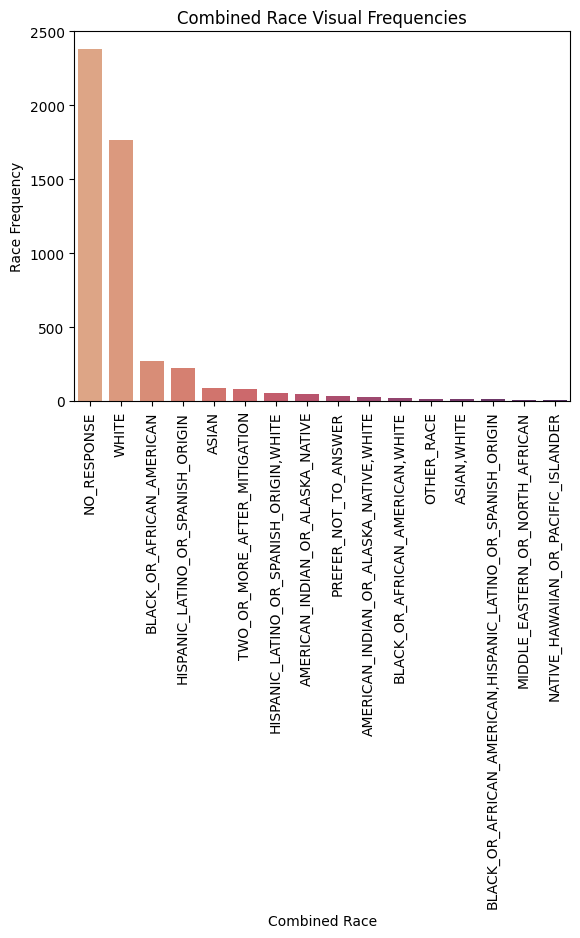

In [ ]:
sns.countplot(df_filtered, x='combined_race', order=df_filtered['combined_race'].value_counts().index, palette='flare')
plt.title("Combined Race Visual Frequencies")
plt.xlabel("Combined Race")
plt.ylabel("Race Frequency")
plt.xticks(rotation=90)
plt.show()

/tmp/ipython-input-3804330662.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_race_viz, x='combined_race', order=df_race_viz['combined_race'].value_counts().index, palette='flare')


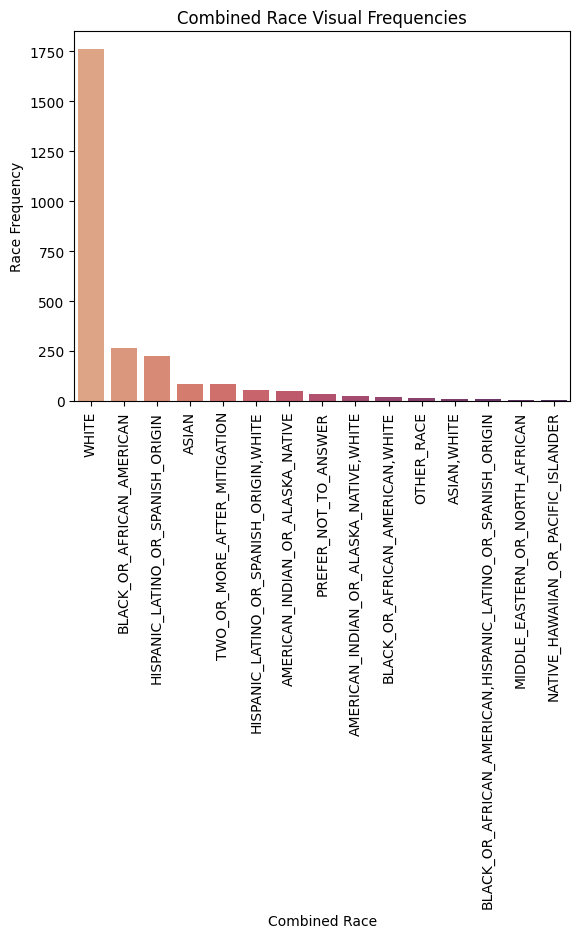

In [35]:
# With no "no_response" value in combined race
# Rerun the first line of code to get the original df_filtered with no "no_response" value in combined race
df_race_viz = df_filtered

sns.countplot(df_race_viz, x='combined_race', order=df_race_viz['combined_race'].value_counts().index, palette='flare')
plt.title("Combined Race Visual Frequencies")
plt.xlabel("Combined Race")
plt.ylabel("Race Frequency")
plt.xticks(rotation=90)
plt.show()

<Axes: ylabel='count'>

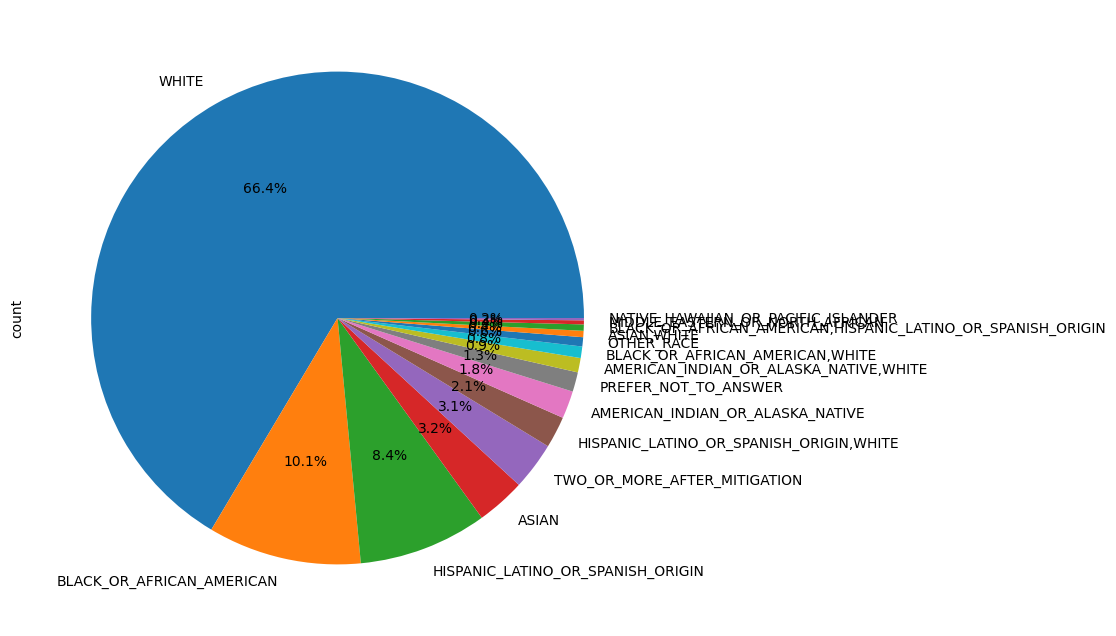

In [39]:
df_race_viz['combined_race'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8))

In [42]:
combined_race_counts = df_race_viz['combined_race'].value_counts()
top_n_race = 6
top_race_counts = combined_race_counts.head(top_n_race)

other_sum = combined_race_counts.iloc[top_n_race:].sum()

plot_top_values = top_race_counts.copy()
if other_sum > 0:
  plot_top_values['Other'] = other_sum

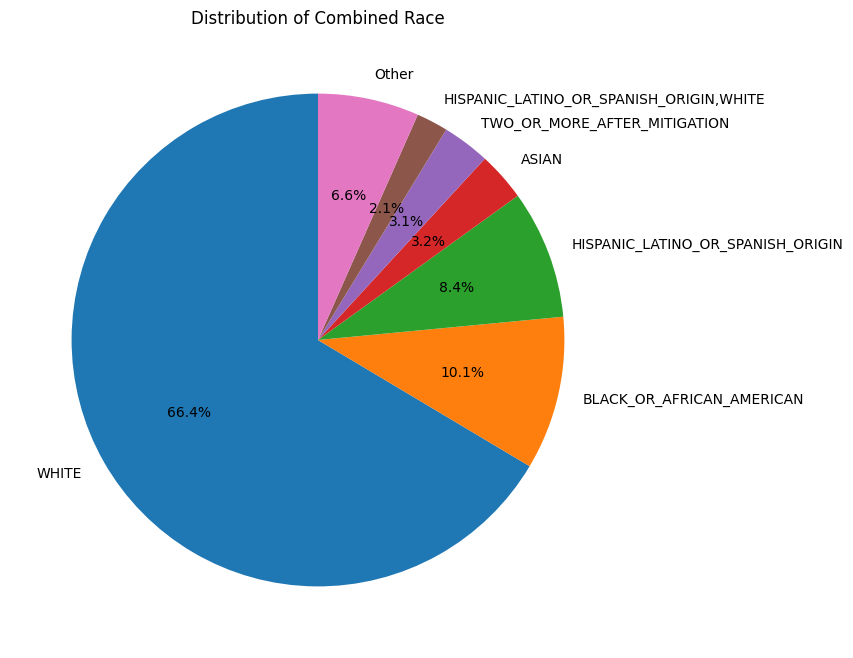

In [43]:
plt.figure(figsize=(8, 8))
plt.pie(plot_top_values, labels=plot_top_values.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of Combined Race')
plt.show()

/tmp/ipython-input-3810566313.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_race_viz, x='combined_race', order=plot_top_values.index, palette='flare')


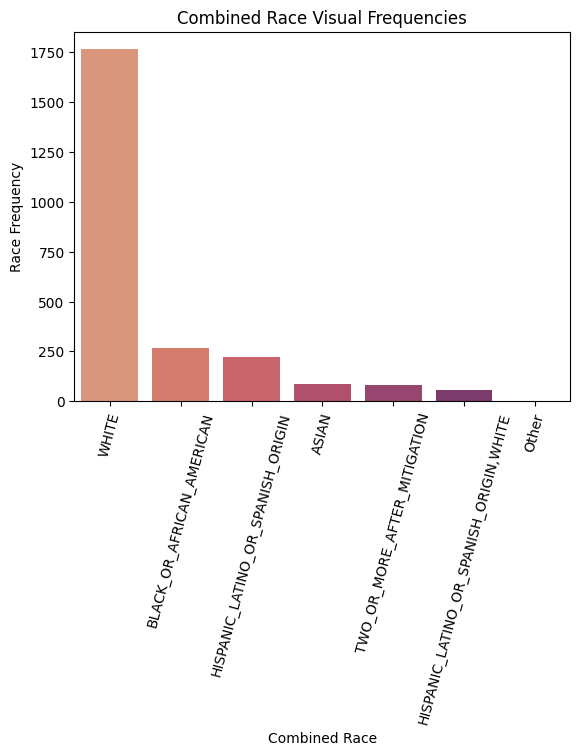

In [49]:
sns.countplot(df_race_viz, x='combined_race', order=plot_top_values.index, palette='flare')
plt.title("Combined Race Visual Frequencies")
plt.xlabel("Combined Race")
plt.ylabel("Race Frequency")
plt.xticks(rotation=75)
plt.show()

## Image Analysis

### Stage 1: Image Quality Analysis

In [ ]:
from google.cloud import storage
# List all images in dataset/images/
all_images = []
for blob in Globals.gcs_bucket.list_blobs(prefix=Globals.gcs_images_dir):
    if blob.name.endswith((".jpg",".jpeg",".png")):
        all_images.append(blob.name)

#### Scan images for common issues using clean vision library

In [ ]:
# To import entire dataset locally (HAS NOT BEEN DONE YET OFFICIALLY)
'''
# Set destination directory
save_dir = "/content/drive/My Drive/BTT Skinterest 2A/Dataset/Original_Google_dataset_images"
os.makedirs(save_dir, exist_ok=True)

# Download all images from GCS to local drive
for path in tqdm(all_images, desc="Downloading images"):
    try:
        blob = Globals.gcs_bucket.blob(path)
        filename = os.path.basename(path)  # keep only the image name
        local_path = os.path.join(save_dir, filename)
        blob.download_to_filename(local_path)
    except Exception as e:
        print(f"Error downloading {path}: {e}")

print(f"\n All images saved to: {save_dir}")
'''

'\n# Set destination directory\nsave_dir = "/content/drive/My Drive/BTT Skinterest 2A/Dataset/Original_Google_dataset_images"\nos.makedirs(save_dir, exist_ok=True)\n\n# Download all images from GCS to local drive\nfor path in tqdm(all_images, desc="Downloading images"):\n    try:\n        blob = Globals.gcs_bucket.blob(path)\n        filename = os.path.basename(path)  # keep only the image name\n        local_path = os.path.join(save_dir, filename)\n        blob.download_to_filename(local_path)\n    except Exception as e:\n        print(f"Error downloading {path}: {e}")\n\nprint(f"\n All images saved to: {save_dir}")\n'

In [ ]:
!pip install cleanvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
!lsb_release -c -s

jammy


In [ ]:
# Clean up any previous bad entries
!rm -f /etc/apt/sources.list.d/gcsfuse.list

# Add the new official gcsfuse repository for Ubuntu 22.04 (Jammy)
!echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt gcsfuse-jammy main" | tee /etc/apt/sources.list.d/gcsfuse.list

# Add the Google Cloud public key
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | gpg --dearmor -o /usr/share/keyrings/cloud.google.gpg

# Update and install gcsfuse
!apt-get update
!apt-get install -y gcsfuse

# Create mount directory and mount the bucket
!mkdir -p /content/gcs_mount
!gcsfuse --implicit-dirs dx-scin-public-data /content/gcs_mount


deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   4353      0 --:--:-- --:--:-- --:--:--  4348
Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://packages.cloud.google.com/apt gcsfuse-jammy InRelease [1,227 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu ja

In [ ]:
'''
DATA_PATH = "/content/gcs_mount/dataset/images"

#  Initialize CleanVision
imagelab = Imagelab(data_path=DATA_PATH)

#  Run full issue detection
print("Starting CleanVision analysis... please wait.")
start = time.time()

# Use all CPU cores and resize images for speed
imagelab.find_issues()

elapsed = (time.time() - start) / 60
print(f"\nCleanVision analysis completed in {elapsed:.2f} minutes.\n")
'''

'\nDATA_PATH = "/content/gcs_mount/dataset/images"\n\n#  Initialize CleanVision\nimagelab = Imagelab(data_path=DATA_PATH)\n\n#  Run full issue detection\nprint("Starting CleanVision analysis... please wait.")\nstart = time.time()\n\n# Use all CPU cores and resize images for speed\nimagelab.find_issues()\n\nelapsed = (time.time() - start) / 60\nprint(f"\nCleanVision analysis completed in {elapsed:.2f} minutes.\n")\n'

In [ ]:
#imagelab.report()

In [ ]:
cols = ['image_1_path', 'image_2_path', 'image_3_path']
Globals.cases_and_labels_df[cols].head(5)

image_1_path  \
0  dataset/images/-3205742176803893704.png   
1  dataset/images/-4762289084741430925.png   
2  dataset/images/-4027806997035329030.png   
3  dataset/images/-5332065579713135540.png   
4  dataset/images/-3799298995660217860.png   

                              image_2_path  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3  dataset/images/-6353431708064969797.png   
4  dataset/images/-5881426422999442186.png   

                             image_3_path  
0                                     NaN  
1                                     NaN  
2                                     NaN  
3   dataset/images/742075435141960831.png  
4  dataset/images/5854025080806696361.png

In [ ]:
# Problematic images identified by CleanVision
to_drop = [
    "dataset/images/-4593817128438983108.png",
    "dataset/images/-2431769699504014881.png"
]

# Columns that contain image paths
image_cols = ['image_1_path', 'image_2_path', 'image_3_path']

# Build a boolean mask for rows that have any of these images
mask = df_filtered[image_cols].isin(to_drop).any(axis=1)

# Apply filter (keep only rows without those images)
df_filtered = df_filtered[~mask].copy()

print(f"Removed {mask.sum()} rows containing problematic images.")
print(f" Filtered dataset now has {len(df_filtered)} rows.")


Removed 2 rows containing problematic images.
 Filtered dataset now has 5031 rows.


#### **Image Duplicate Detection using Python Library: ImageDedup** <br>
https://github.com/idealo/imagededup

In [ ]:
# Find duplicates using python library ImageDedup
!pip install imagededup

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
# Convolutional Neural Network method from ImageDedup for identifying duplicate images.
from imagededup.methods import CNN
cnn = CNN()
duplicates = cnn.find_duplicates(image_dir=image_dir, min_similarity_threshold=0.9)
# Print the duplicate groups
for key, value in duplicates.items():
    if value: # Only print if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")

2025-10-27 23:34:23,839: INFO Device set to cpu ..
INFO:imagededup.methods.cnn:Device set to cpu ..
2025-10-27 23:34:23,846: INFO Initialized: mobilenet_v3_small for feature extraction ..
INFO:imagededup.methods.cnn:Initialized: mobilenet_v3_small for feature extraction ..
2025-10-27 23:34:23,849: INFO Start: Image encoding generation
INFO:imagededup.methods.cnn:Start: Image encoding generation


KeyboardInterrupt: 

In [ ]:
from imagededup.utils import plot_duplicates
# Plot/show the images stored in duplicates
# Lots of similar images, end the execution early to get a sense of the duplicated images
for key, value in duplicates.items():
    if value: # Only plot if there are duplicates for this image
        print(f"Duplicates for {key}: {value}")
        plot_duplicates(image_dir=image_dir, duplicate_map=duplicates, filename=key)
        print(" ")

NameError: name 'duplicates' is not defined

In [ ]:
num_of_similar_images = 0

for image_filename in duplicates:
    num_of_similar_images += len(duplicates[image_filename])

print(f"The total number of closely similar/duplicate image files found is: {num_of_similar_images}")

NameError: name 'duplicates' is not defined

#### Image analysis

In [ ]:
save_dir = "/content/drive/My Drive/BTT_Skinterest_2A/Dataset"
os.makedirs(save_dir, exist_ok=True)


The goal is to assess technical factors such as blur, exposure, contrast, and shadow presence, which primarily depend on luminance (the perceived brightness of pixels) rather than their chromatic (color) components.


**Luminance Histogram**

Converting images to grayscale simplifies this process by collapsing the three color channels (Red, Green, Blue) into a single intensity channel. This reduces computational complexity and eliminates redundant color information that does not significantly affect the measurements of sharpness or exposure.


Blur detection uses edge variance (via the Laplacian operator), which relies on intensity gradients rather than color differences.

Brightness and exposure metrics depend on pixel intensity distributions.

Contrast and shadow evaluations are based on light–dark relationships, independent of hue.

Thus, grayscale provides a cleaner, noise-reduced representation for these low-level quality features, ensuring that color variation does not falsely influence results.


In [ ]:

'''
def evaluate_image(blob):
    """Download one image blob and compute quality features."""
    img_bytes = blob.download_as_bytes()
    # Each byte = 8 bits ; 8 bits per channel allows intensity values from 0–255, which is the standard in most digital image formats (aka matrix format).
    img_array = np.frombuffer(img_bytes, np.uint8)
    # Decodes the compressed JPEG/PNG bytes, and returns a NumPy array representing the image
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # Converts the color image into grayscale to evaluate brightness, blur, and contrast without color difference
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur
    blur = cv2.Laplacian(gray, cv2.CV_64F).var() # converts the image from color (3 channels: Blue, Green, Red) → to grayscale

    # Brightness stats
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist = hist.ravel() / hist.sum()
    mean = (hist * np.arange(256)).sum()
    std = np.sqrt((hist * (np.arange(256)-mean)**2).sum())
    under_exp = hist[:30].sum()
    over_exp = hist[220:].sum()

    # Contrast
    contrast = (gray.max() - gray.min()) / (gray.max() + 1e-6)

    # Shadows
    shadow_pixels = (gray < mean - 1.5*std).sum()
    shadow = shadow_pixels / gray.size

    return blur, mean, std, under_exp, over_exp, contrast, shadow

#evaluate images
results = []

for path in tqdm(all_images):
    blob = Globals.gcs_bucket.blob(path)
    try:
        blur, mean, std, under, over, contrast, shadow = evaluate_image(blob)
        results.append({
            "image_path": path,
            "blur": blur,
            "brightness_mean": mean,
            "brightness_std": std,
            "underexp": under,
            "overexp": over,
            "contrast": contrast,
            "shadow": shadow
        })
    except Exception as e:
        results.append({
            "image_path": path,
            "status": f"error: {e}"
        })

quality_df = pd.DataFrame(results)
save_path = os.path.join(save_dir, "image_quality_report.csv")
quality_df.to_csv(save_path, index=False)
print("Saved report to:", save_path)
quality_df.head()
'''

'\ndef evaluate_image(blob):\n    """Download one image blob and compute quality features."""\n    img_bytes = blob.download_as_bytes()\n    # Each byte = 8 bits ; 8 bits per channel allows intensity values from 0–255, which is the standard in most digital image formats (aka matrix format).\n    img_array = np.frombuffer(img_bytes, np.uint8)\n    # Decodes the compressed JPEG/PNG bytes, and returns a NumPy array representing the image\n    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)\n    # Converts the color image into grayscale to evaluate brightness, blur, and contrast without color difference\n    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n\n    # Blur\n    blur = cv2.Laplacian(gray, cv2.CV_64F).var() # converts the image from color (3 channels: Blue, Green, Red) → to grayscale\n\n    # Brightness stats\n    hist = cv2.calcHist([gray],[0],None,[256],[0,256])\n    hist = hist.ravel() / hist.sum()\n    mean = (hist * np.arange(256)).sum()\n    std = np.sqrt((hist * (np.arange(2

In [ ]:
!pip install opencv-python-headless numpy matplotlib tqdm pandas cupy-cuda12x

In [ ]:
import os, cv2, numpy as np, cupy as cp, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_image_and_hist_gpu(blob, hist_dir):
    img_bytes = blob.download_as_bytes()
    np_img = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(np_img, cv2.IMREAD_COLOR)

    # --- Upload to GPU ---
    gpu_img = cv2.cuda_GpuMat()
    gpu_img.upload(img)

    # Convert to grayscale on GPU
    gpu_gray = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2GRAY)

    # Laplacian (blur)
    gpu_lap = cv2.cuda.Laplacian(gpu_gray, cv2.CV_64F)
    blur = float(cp.var(cp.asarray(gpu_lap.download())))

    # Download grayscale back to CPU for histogram & brightness metrics
    gray = gpu_gray.download()
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()

    mean = (hist * np.arange(256)).sum()
    std = np.sqrt((hist * (np.arange(256) - mean) ** 2).sum())
    under_exp = hist[:30].sum()
    over_exp = hist[220:].sum()
    contrast = (gray.max() - gray.min()) / (gray.max() + 1e-6)
    shadow_pixels = (gray < mean - 1.5 * std).sum()
    shadow = shadow_pixels / gray.size

    # --- Save histogram plot ---
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.plot(hist, color='gray')
    plt.xlim([0, 255])
    plt.tight_layout()

    filename = os.path.basename(blob.name)
    hist_path = os.path.join(hist_dir, filename.replace('.png', '_hist.png'))
    plt.savefig(hist_path, bbox_inches='tight')
    plt.close()

    return blur, mean, std, under_exp, over_exp, contrast, shadow, hist_path


To determine exposure, contrast, and shadow an historgram is used.

**A histogram is like a bar graph that tells you how bright or dark your picture is.**

* On the bottom (X-axis), you have brightness:
    * 0 = totally black
    * 255 = totally white
* On the side (Y-axis), you have how many pixels have that brightness.


In the code we first:

1. Looks at every pixel.

2. Figures out how bright that pixel is.

3. Puts that brightness into a bucket (0–255).

4. Counts how many pixels are in each bucket.

In [ ]:
save_path = os.path.join(save_dir, "image_quality_report.csv")
quality_df = pd.read_csv(save_path)
print("Loaded", len(quality_df), "rows")
quality_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/BTT_Skinterest_2A/Dataset/image_quality_report.csv'

| **Feature**            | **Calculation**                     | **Meaning**             | **Interpretation**                     |
|-------------------------|--------------------------------------|-------------------------|-----------------------------------------|
| **Blur score**         | Variance of Laplacian                | Edge sharpness          | Low = blurry, High = sharp              |
| **Brightness mean**    | Weighted mean of pixel histogram     | Avg light level         | Low = dark, High = bright               |
| **Brightness std**     | Std dev of pixel histogram           | Spread of brightness    | Low = flat, High = strong contrast      |
| **Underexposed ratio** | % of pixels < 30                     | Dark pixel proportion   | High = underexposed                     |
| **Overexposed ratio**  | % of pixels > 220                    | Bright pixel proportion | High = overexposed                      |
| **Contrast ratio**     | (max − min) / max                    | Global contrast level   | Low = washed-out, High = clear contrast |
| **Shadow score**       | % pixels < (mean − 1.5 × std)        | Shadow prevalence       | High = harsh shadows                    |


In [ ]:
BRIGHTNESS_THRESHOLD = 35

# Filter images below threshold
low_brightness = quality_df[quality_df["brightness_mean"] < BRIGHTNESS_THRESHOLD].copy()

print(f"Found {len(low_brightness)} low-brightness images (brightness < {BRIGHTNESS_THRESHOLD}).")
low_brightness.head()


NameError: name 'quality_df' is not defined

In [ ]:
darkest_images = low_brightness.sort_values("brightness_mean", ascending=True).head(25)
print(darkest_images[["image_path", "brightness_mean"]])

n_cols = 3
n_rows = int(np.ceil(len(darkest_images) / n_cols))
plt.figure(figsize=(12, 4 * n_rows))

for idx, row in enumerate(darkest_images.itertuples(), 1):
    gcs_path = row.image_path
    brightness = row.brightness_mean
    img = read_image_from_gcs(gcs_path)

    plt.subplot(n_rows, n_cols, idx)
    if img is not None:
        plt.imshow(img)
        plt.title(f"{os.path.basename(gcs_path)}\nBrightness: {brightness:.2f}", fontsize=9)
    else:
        plt.text(0.5, 0.5, "Unreadable", ha='center', va='center')
    plt.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'low_brightness' is not defined

In [ ]:
# Problematic images identified by CleanVision
to_drop_2 = [
    "dataset/images/4207723573736028617.png",
]

mask_2 = df_filtered[image_cols].isin(to_drop_2).any(axis=1)
df_filtered = df_filtered.loc[~mask_2]

print(f"Removed {mask_2.sum()} rows containing problematic images.")
print(f" Filtered dataset now has {len(df_filtered)} rows.")

Removed 1 rows containing problematic images.
 Filtered dataset now has 5030 rows.


In [ ]:
for path in quality_df['image_path'][:5]:
    blob = Globals.gcs_bucket.blob(path)
    img_bytes = blob.download_as_bytes()
    img_array = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0,256])
    hist = hist.ravel() / hist.sum()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.plot(hist, color='gray')
    plt.xlim([0, 255])
    plt.show()


NameError: name 'quality_df' is not defined

In [ ]:
'''
import cv2, numpy as np, pandas as pd, os
from tqdm import tqdm

os.makedirs(save_dir, exist_ok=True)

csv_path = os.path.join(save_dir, "image_quality_report.csv")

if os.path.exists(csv_path):
    quality_df = pd.read_csv(csv_path)
    print(f" Loaded existing dataset: {csv_path} ({len(quality_df)} rows)")
else:
    quality_df = pd.DataFrame({'image_path': all_images})
    print(f" No existing quality report found. Created new DataFrame with {len(quality_df)} image paths.")

def compute_sharpness(blob):
    """Download one image blob and compute variance of Laplacian (sharpness)."""
    img_bytes = blob.download_as_bytes()
    img_array = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
    return sharpness

sharpness_scores = []

for path in tqdm(quality_df['image_path'], desc="Calculating Sharpness"):
    blob = Globals.gcs_bucket.blob(path)
    try:
        score = compute_sharpness(blob)
        sharpness_scores.append(score)
    except Exception as e:
        sharpness_scores.append(np.nan)
        print(f" Error with {path}: {e}")

quality_df['sharpness'] = sharpness_scores

output_path = os.path.join(save_dir, "image_quality_report_with_sharpness.csv")
quality_df.to_csv(output_path, index=False)

print(f"Sharpness computed and added successfully. Saved to:\n{output_path}")
display(quality_df.head())
'''

'\nimport cv2, numpy as np, pandas as pd, os\nfrom tqdm import tqdm\n\nos.makedirs(save_dir, exist_ok=True)\n\ncsv_path = os.path.join(save_dir, "image_quality_report.csv")\n\nif os.path.exists(csv_path):\n    quality_df = pd.read_csv(csv_path)\n    print(f" Loaded existing dataset: {csv_path} ({len(quality_df)} rows)")\nelse:\n    quality_df = pd.DataFrame({\'image_path\': all_images})\n    print(f" No existing quality report found. Created new DataFrame with {len(quality_df)} image paths.")\n\ndef compute_sharpness(blob):\n    """Download one image blob and compute variance of Laplacian (sharpness)."""\n    img_bytes = blob.download_as_bytes()\n    img_array = np.frombuffer(img_bytes, np.uint8)\n    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)\n    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()\n    return sharpness\n\nsharpness_scores = []\n\nfor path in tqdm(quality_df[\'image_path\'], desc="Calculating Sharpness"):\n    blob 

In [ ]:
# --- Undertone Extraction (Warm / Cool / Neutral) ---
import cv2
import numpy as np
from tqdm import tqdm

def analyze_undertone_from_blob(blob):
    """Classify undertone from LAB color space (warm, cool, neutral)."""
    try:
        img_bytes = blob.download_as_bytes()
        img_array = np.frombuffer(img_bytes, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        mean_a = np.mean(a)
        mean_b = np.mean(b)

        # Example threshold values (tune if needed)
        if mean_b > 140 and mean_a > 135:
            return "warm"
        elif mean_b < 125:
            return "cool"
        else:
            return "neutral"
    except Exception as e:
        print("Error analyzing undertone:", e)
        return None

print("Analyzing undertones for all images...")

undertones = []
for path in tqdm(quality_df["image_path"], desc="Extracting Undertones"):
    blob = Globals.gcs_bucket.blob(path)
    undertones.append(analyze_undertone_from_blob(blob))

quality_df["undertone"] = undertones

# Save updated CSV with undertones added
output_path = os.path.join(save_dir, "image_quality_report_with_undertones.csv")
quality_df.to_csv(output_path, index=False)

print(f"Undertones added successfully! Saved to:\n{output_path}")
display(quality_df.head())

Analyzing undertones for all images...


NameError: name 'quality_df' is not defined

In [ ]:
save_path = os.path.join(save_dir, "image_quality_report_with_sharpness.csv")
quality_df = pd.read_csv(save_path)
print("Loaded", len(quality_df), "rows")
quality_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/BTT_Skinterest_2A/Dataset/image_quality_report_with_sharpness.csv'

#Resizing Images

In [ ]:
# --- Image Standardization and Color Space Transformation ---

import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

# Directory containing dataset images
data_dir = "/content/drive/MyDrive/BTT Skinterest 2A/Dataset/images"
output_dir = "/content/drive/MyDrive/BTT Skinterest 2A/Dataset/resized_images"

os.makedirs(output_dir, exist_ok=True)

IMG_SIZE = (224, 224)

def resize_and_normalize(image_path, output_dir):
    """Resize image to 224x224, convert to HSV & LAB, and normalize pixel values."""
    try:
        # Read image using OpenCV (BGR format)
        img = cv2.imread(image_path)
        if img is None:
            print(f"⚠️ Skipped (cannot read): {image_path}")
            return None

        # Resize to consistent dimensions
        resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Convert to RGB
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

        # Convert to other color spaces
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

        # Normalize pixel values to [0,1]
        rgb_norm = rgb / 255.0
        hsv_norm = hsv / 255.0
        lab_norm = lab / 255.0

        # Save resized RGB image (optional)
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_dir, filename)
        cv2.imwrite(save_path, cv2.cvtColor((rgb_norm * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        return {
            "image_path": image_path,
            "resized_path": save_path,
            "rgb_shape": rgb_norm.shape,
            "hsv_shape": hsv_norm.shape,
            "lab_shape": lab_norm.shape
        }

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Process all images in dataset
image_metadata = []
for img_name in tqdm(os.listdir(data_dir), desc="Resizing & Normalizing Images"):
    img_path = os.path.join(data_dir, img_name)
    result = resize_and_normalize(img_path, output_dir)
    if result:
        image_metadata.append(result)

print(f"✅ Finished processing {len(image_metadata)} images.")
